In [1]:
%matplotlib inline
import gc

import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm

import librosa
import librosa.display

import torch
import torch.nn as nn
from torchsummary import summary

import util
import audio_ss_dataset
import base_nnio
import mag_nnio
import models.base_models

torch.manual_seed(0)
np.random.seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float

print(device)



/usr/local/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/usr/local/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


cpu


# Load Dataset

In [2]:
num_sources = 2

sr, duration = 8000, 2.0

np.random.seed(0)
source1 = np.load(f'datasets/voices_sr{sr}_dur{duration}.npy')
np.random.shuffle(source1)
source1 = torch.from_numpy(source1)

np.random.seed(0)
source2 = 0.5 * np.load(f'datasets/air_conditioning_sr{sr}_dur{duration}_num15000.npy')
np.random.shuffle(source2)
source2 = torch.from_numpy(source2)

audiossds_test = audio_ss_dataset.AudioSSDS(sr, duration, sources=(source1[:10], source2[:10]))
audiossds_train = audio_ss_dataset.AudioSSDS(sr, duration, sources=(source1[10:], source2[10:]))
# audionnio = base_nnio.BaseNNIO(sr, duration, normalized=True, magphase_representation=True)
audionnio = mag_nnio.MagNNIO(sr, duration, normalized=True)


x, y = audiossds_test[:1]
input_shape, output_shape = audionnio.audio_to_nn_input(x)[0].shape, audionnio.audio_to_nn_output(y).shape
print('nn input shape: ', input_shape)
print('nn output shape: ', output_shape)

nn input shape:  torch.Size([1, 1, 151, 214])
nn output shape:  torch.Size([1, 1, 151, 214])


# Manual Method
Seperating the frequency manually from spectrogram

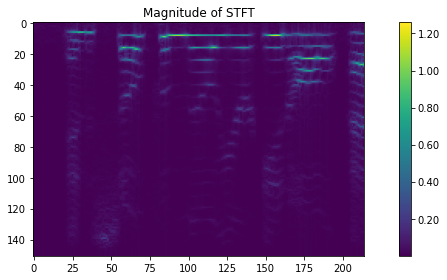

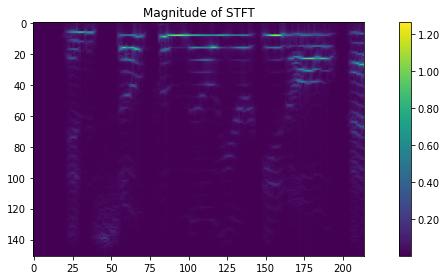

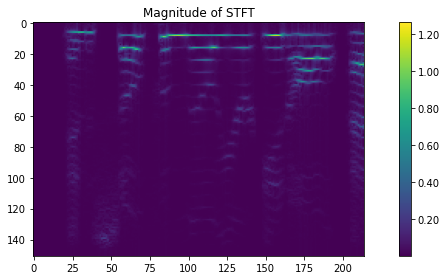

In [4]:
sample_idx = 4

X_test, Y_test = audiossds_test[:]

audionnio.show_play_audio(X_test[sample_idx], ['mag', 'audio'])

audionnio.show_play_audio(Y_test[sample_idx, 0], ['mag', 'audio'])

X_test, X_test_phase = audionnio.audio_to_nn_input(X_test)
Y_test = audionnio.audio_to_nn_output(Y_test)

audionnio.show_play_nn_output(Y_test, X_test, X_test_phase, True, ['mag','audio'], sample_idx)


# Model Definitions

In [5]:
model_g = models.base_models.FTCNNGenerator(input_shape[0], [6, 6, 6 ,6], 
                         num_layers_per_block=4, block_gr=24).to(device, dtype)
# model_g = torch.load('models/ftnn_naive_epochs300.pth')
summary(model_g, input_size=input_shape[1:])

model_d = models.base_models.FTCNNDiscrimminator(input_shape[0], [6, 6, 6, 6], input_hw = input_shape[2:], 
                              num_layers_per_block=4, block_gr=24).to(device, dtype)
summary(model_d, input_size=input_shape[1:])


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 151, 214]              12
       BatchNorm2d-2          [-1, 6, 151, 214]              12
              ReLU-3          [-1, 6, 151, 214]               0
            Conv2d-4         [-1, 24, 151, 214]           1,320
       BatchNorm2d-5         [-1, 30, 151, 214]              60
              ReLU-6         [-1, 30, 151, 214]               0
            Conv2d-7         [-1, 24, 151, 214]           6,504
       BatchNorm2d-8         [-1, 54, 151, 214]             108
              ReLU-9         [-1, 54, 151, 214]               0
           Conv2d-10         [-1, 24, 151, 214]          11,688
      BatchNorm2d-11         [-1, 78, 151, 214]             156
             ReLU-12         [-1, 78, 151, 214]               0
           Conv2d-13          [-1, 6, 151, 214]           4,218
  NeuralTransform-14          [-1, 6, 1

# Base Method

Make a neural network to just take out the tone

In [6]:
mse = nn.MSELoss()
bce = nn.BCELoss()

import pytorch_ssim

lambda_mse = 1e2
lambda_noise_weighted_mse = 1e4
lambda_ssim = 0.0

def generator_loss_function_base(Y_batch_pred, Y_batch, X_batch):
    # normal MSE loss for now
    Y_batch_noise = X_batch-Y_batch
    Y_batch_noise_pred = X_batch-Y_batch_pred
    
    # normal mse loss
    loss_mse = lambda_mse * mse(Y_batch_pred, Y_batch)
    
    # noise weighted mse loss
    loss_noise_weighted_mse = lambda_noise_weighted_mse * torch.mean(((Y_batch_pred-Y_batch)**2) * torch.abs(Y_batch_noise))
    
    # SSIM loss
#     loss_ssim = lambda_ssim * (2 - pytorch_ssim.ssim(Y_batch, Y_batch_pred) - pytorch_ssim.ssim(Y_batch_noise, Y_batch_noise_pred))
    loss_ssim = 0.0
    
    # total loss
    loss = loss_mse + loss_noise_weighted_mse + loss_ssim
    print(f'{loss_mse}+{loss_noise_weighted_mse}+{loss_ssim}={loss}')
    
    return loss

In [7]:
X_test, Y_test = audiossds_test[:50]
X_test, Y_test = audionnio.audio_to_nn_input(X_test), audionnio.audio_to_nn_output(Y_test)
X_test, X_test_phase = X_test
print(X_test.shape)
print(Y_test.shape)

torch.Size([10, 1, 151, 214])
torch.Size([10, 1, 151, 214])


In [8]:
with torch.no_grad():
    Y_test_pred = model_g(X_test.to(device,dtype)).cpu()

print('Test Loss: ', generator_loss_function_base(Y_test_pred, Y_test, X_test).item())


12.037047386169434+29.426321029663086+0.0=41.4633674621582
Test Loss:  41.4633674621582


Showing example:  0
Input:


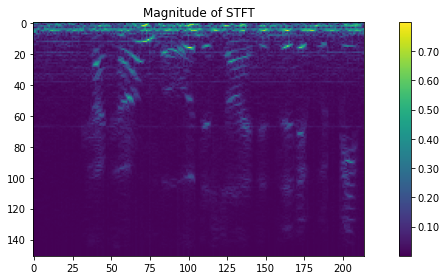

Target:


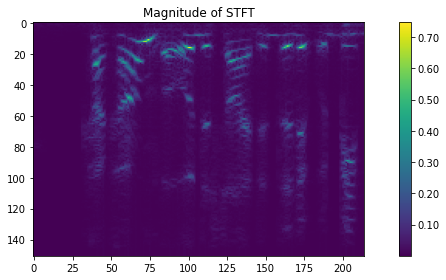

Output:


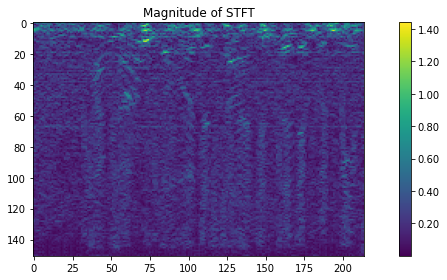

In [10]:
test_example_idx = 0
print('Showing example: ', test_example_idx)
print('Input:')
audionnio.show_play_nn_input(X_test, X_test_phase, ts=['mag', 'audio'], sample_idx=test_example_idx)
print('Target:')
audionnio.show_play_nn_output(Y_test, X_test, X_test_phase, ts=['mag', 'audio'], sample_idx=test_example_idx)
print('Output:')
audionnio.show_play_nn_output(Y_test_pred, X_test, X_test_phase, ts=['mag', 'audio'], sample_idx=test_example_idx)

In [11]:
util.clear_mem(True)

11.816490173339844+19.374404907226562+0.0=31.190895080566406



33.534637451171875+114.59918975830078+0.0=148.13381958007812



8.351117134094238+16.940223693847656+0.0=25.291339874267578



2.635526418685913+3.6296451091766357+0.0=6.265171527862549



5.03156852722168+7.422086238861084+0.0=12.453655242919922



5.576584815979004+7.10563325881958+0.0=12.682218551635742



3.4942898750305176+3.5508196353912354+0.0=7.045109748840332



3.0382535457611084+3.8567419052124023+0.0=6.89499568939209



2.1265604496002197+2.954498529434204+0.0=5.081058979034424



1.4341388940811157+1.9530971050262451+0.0=3.3872361183166504



1.4307658672332764+1.8056527376174927+0.0=3.2364187240600586



1.4368555545806885+1.7140649557113647+0.0=3.1509203910827637



1.2350167036056519+1.4607878923416138+0.0=2.6958045959472656



1.008428692817688+1.319631814956665+0.0=2.3280606269836426



0.8583539128303528+1.3324360847473145+0.0=2.1907899379730225



0.7313449382781982+1.27769136428833+0.0=2.0090363025665283



0.6076679229736328+1.0914582014083862+0.0=1.699126124382019



0.5403379201889038+0.9104920625686646+0.0=1.4508299827575684



0.5500231385231018+0.8462164998054504+0.0=1.3962396383285522



0.581609308719635+0.8613535761833191+0.0=1.442962884902954



0.5682045817375183+0.8545786738395691+0.0=1.4227832555770874



0.5028899908065796+0.8002349138259888+0.0=1.3031249046325684



0.4279865026473999+0.7475345134735107+0.0=1.1755210161209106



0.37728869915008545+0.7314451336860657+0.0=1.108733892440796



0.3471730649471283+0.7263636589050293+0.0=1.07353675365448



0.31869620084762573+0.6867881417274475+0.0=1.0054843425750732



0.2923959791660309+0.6155970096588135+0.0=0.907992959022522



0.28641143441200256+0.5565629601478577+0.0=0.8429744243621826



0.30669161677360535+0.5363222360610962+0.0=0.8430138826370239



0.33316782116889954+0.5383278727531433+0.0=0.8714957237243652



0.3387162983417511+0.5315708518028259+0.0=0.8702871799468994



0.31594619154930115+0.5093632936477661+0.0=0.8253095149993896



0.28090864419937134+0.4895838499069214+0.0=0.7704924941062927



0.25384870171546936+0.48577654361724854+0.0=0.7396252155303955



0.24114041030406952+0.48914939165115356+0.0=0.7302898168563843



0.23592768609523773+0.4824509918689728+0.0=0.7183786630630493



0.2313099354505539+0.4619038701057434+0.0=0.6932138204574585



0.22776730358600616+0.4387795925140381+0.0=0.6665468811988831



0.22841128706932068+0.42321187257766724+0.0=0.6516231298446655



0.23168623447418213+0.4147236943244934+0.0=0.6464099287986755



0.23159873485565186+0.4088185131549835+0.0=0.640417218208313



0.22366836667060852+0.4053072929382324+0.0=0.6289756298065186



0.20921209454536438+0.40609872341156006+0.0=0.615310788154602



0.19397799670696259+0.40836864709854126+0.0=0.602346658706665



0.1839483678340912+0.4056397080421448+0.0=0.5895880460739136



0.18187060952186584+0.3956602215766907+0.0=0.5775308609008789



0.18596886098384857+0.38291916251182556+0.0=0.5688880085945129



0.19106648862361908+0.3723151385784149+0.0=0.5633816123008728



0.19213837385177612+0.36397257447242737+0.0=0.5561109781265259



0.18784262239933014+0.35626456141471863+0.0=0.54410719871521



0.1807306706905365+0.35015398263931274+0.0=0.5308846235275269



0.17403173446655273+0.3475588858127594+0.0=0.5215905904769897



0.1689082384109497+0.34690606594085693+0.0=0.5158143043518066



0.16509872674942017+0.3438834249973297+0.0=0.5089821815490723



0.1628788262605667+0.33703723549842834+0.0=0.49991607666015625



0.16284741461277008+0.3293558359146118+0.0=0.4922032356262207



0.1639387160539627+0.3238380551338196+0.0=0.4877767562866211



0.16342543065547943+0.32011234760284424+0.0=0.48353779315948486



0.1596631556749344+0.3166269361972809+0.0=0.47629010677337646



0.1538856029510498+0.3135288655757904+0.0=0.4674144685268402



0.1487656831741333+0.31157270073890686+0.0=0.46033838391304016



0.14578032493591309+0.3096682131290436+0.0=0.45544853806495667



0.14467927813529968+0.3055860698223114+0.0=0.4502653479576111



0.14472785592079163+0.29927000403404236+0.0=0.443997859954834



0.1452966183423996+0.2927951514720917+0.0=0.4380917549133301



0.14550840854644775+0.28771692514419556+0.0=0.4332253336906433



0.14438454806804657+0.2840133607387543+0.0=0.42839789390563965



0.14174264669418335+0.28136780858039856+0.0=0.4231104552745819



0.13843858242034912+0.27953797578811646+0.0=0.4179765582084656



0.13560405373573303+0.27754175662994385+0.0=0.4131458103656769



0.13394299149513245+0.27427294850349426+0.0=0.4082159399986267



0.13356353342533112+0.26975974440574646+0.0=0.40332329273223877



0.133872851729393+0.26518046855926514+0.0=0.39905333518981934



0.13371549546718597+0.2613793909549713+0.0=0.3950948715209961



0.1322232335805893+0.2584008276462555+0.0=0.3906240463256836



0.1295623928308487+0.2562797963619232+0.0=0.3858422040939331



0.12670868635177612+0.25481924414634705+0.0=0.38152793049812317



0.12452573329210281+0.25314661860466003+0.0=0.37767234444618225



0.12328546494245529+0.25044843554496765+0.0=0.37373390793800354



0.12279831618070602+0.24688561260700226+0.0=0.3696839213371277



0.12259571999311447+0.2432475984096527+0.0=0.3658433258533478



0.1221172958612442+0.23999838531017303+0.0=0.36211568117141724



0.12105672061443329+0.2372286021709442+0.0=0.3582853078842163



0.11959390342235565+0.2349756360054016+0.0=0.35456955432891846



0.1181471198797226+0.2329358160495758+0.0=0.3510829210281372



0.11698669195175171+0.23063340783119202+0.0=0.3476200997829437



0.11613667011260986+0.2279772013425827+0.0=0.34411388635635376



0.11539825052022934+0.2253943234682083+0.0=0.34079256653785706



0.11447495967149734+0.223155677318573+0.0=0.33763062953948975



0.11320444941520691+0.22121472656726837+0.0=0.3344191908836365



0.11176812648773193+0.21946482360363007+0.0=0.3312329649925232



0.11048653721809387+0.2177027463912964+0.0=0.32818928360939026



0.10956458002328873+0.21565769612789154+0.0=0.32522228360176086



0.10898175835609436+0.2132723480463028+0.0=0.32225412130355835



0.10853033512830734+0.21083948016166687+0.0=0.3193698227405548



0.10789597779512405+0.20867912471294403+0.0=0.3165751099586487



0.10693073272705078+0.20683279633522034+0.0=0.3137635290622711



0.10578280687332153+0.20520849525928497+0.0=0.3109912872314453



0.10471579432487488+0.20361308753490448+0.0=0.30832886695861816



0.10392686724662781+0.2017946094274521+0.0=0.3057214617729187


CPU times: user 13min 5s, sys: 2min 10s, total: 15min 16s
Wall time: 14min 30s


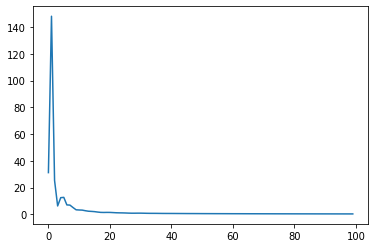

In [12]:
%%time

torch.manual_seed(0)
np.random.seed(0)

num_epochs = 100
batch_size = 10
opt = torch.optim.Adam(model_g.parameters(), lr=0.001)

losses = []
epoch_pbar = tqdm(range(num_epochs), desc='Epochs')

model_g = model_g.train()
for epoch_idx in epoch_pbar:
    all_batch_indices = util.get_batch_indices(np.arange(len(audiossds_test)), batch_size)
    batch_pbar = tqdm(all_batch_indices, desc=f'Epoch {epoch_idx} Batches')
    for batch_idxs in batch_pbar:
        X_batch, Y_batch = audiossds_train[batch_idxs]
        X_batch, Y_batch = audionnio.audio_to_nn_input(X_batch), audionnio.audio_to_nn_output(Y_batch)
        X_batch, X_batch_phase = X_batch
        X_batch, Y_batch = X_batch.to(device, dtype), Y_batch.to(device, dtype)

        opt.zero_grad()
        Y_batch_pred = model_g(X_batch)
        loss = generator_loss_function_base(Y_batch_pred, Y_batch, X_batch)
        loss.backward()
        opt.step()

        loss = loss.item()
        losses.append(loss)
        batch_pbar.set_postfix({'Loss':loss})
model_g = model_g.eval()

plt.plot(np.arange(len(losses)), losses)

del X_batch, Y_batch, Y_batch_pred, loss, losses

In [13]:
util.clear_mem(True)

In [14]:
with torch.no_grad():
    Y_test_pred = model_g(X_test.to(device,dtype)).cpu()

print('Test Loss: ', generator_loss_function_base(Y_test_pred, Y_test, X_test).item())


0.181160569190979+3.8473851680755615+0.0=4.02854585647583
Test Loss:  4.02854585647583


Showing example:  0
Input:


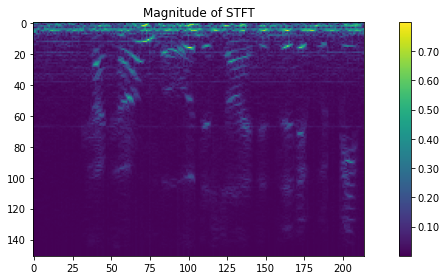

Target:


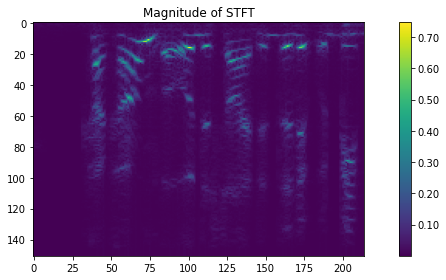

Output:


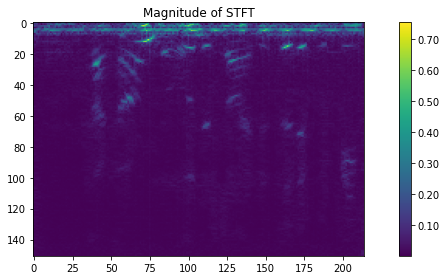

In [15]:
test_example_idx = 0
print('Showing example: ', test_example_idx)
print('Input:')
audionnio.show_play_nn_input(X_test, X_test_phase, ts=['mag', 'audio'], sample_idx=test_example_idx)
print('Target:')
audionnio.show_play_nn_output(Y_test, X_test, X_test_phase, ts=['mag', 'audio'], sample_idx=test_example_idx)
print('Output:')
audionnio.show_play_nn_output(Y_test_pred, X_test, X_test_phase, ts=['mag', 'audio'], sample_idx=test_example_idx)

### Save the model

In [26]:
torch.save(model_g, f'models/model_g_base_big_epochs{100}_testing_set.pth')

# Our Method

Generator-Discriminator setup (without GAN)

In [16]:
def discriminator_loss_function_base(real_out, fake_out):
    return bce(real_out, torch.ones_like(real_out)) + bce(fake_out, torch.zeros_like(fake_out))

def generator_loss_function_gan(X_batch, Y_batch, Y_batch_pred, model_d):
    Yp_batch = X_batch - Y_batch # the noise
    Yp_batch_pred = X_batch - Y_batch_pred
    
    d_Y_batch_pred = model_d(Y_batch_pred)
    d_Yp_batch_pred = model_d(Yp_batch_pred)
    
#     loss1 = mse_crit(Y_batch_pred, Y_batch)
#     loss2 = mse_crit(Yp_batch, Yp_batch_pred) # EXACT same the previous
    loss1 = 0.
    
    loss3 = bce(d_Y_batch_pred, torch.ones_like(d_Y_batch_pred))
    loss4 = bce(d_Yp_batch_pred, torch.zeros_like(d_Yp_batch_pred))
    
    total_loss = loss1+loss3+loss4
    
    return total_loss

### Training Discriminator

In [18]:
with torch.no_grad():
    Y_test_pred = model_g(X_test)

    fake_out = model_d(Y_test_pred)
    real_out = model_d(Y_test)

    test_loss = discriminator_loss_function_base(real_out, fake_out).item()
    accuracy = (((fake_out<0.5).sum() + (real_out>0.5).sum())/float(len(fake_out)+len(real_out))).item()

print('Test Loss: ', test_loss)
print('Accuracy: ', accuracy)


Test Loss:  1.385483741760254
Accuracy:  0.5


In [20]:
util.clear_mem(True)

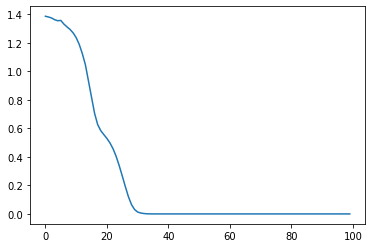

In [24]:
# %%time
model_d = model_d.train()

torch.manual_seed(0)
np.random.seed(0)

num_epochs = 100
batch_size = 10
opt = torch.optim.Adam(model_d.parameters(), lr=0.001)

losses = []
epoch_pbar = tqdm(range(num_epochs), desc='Epochs')

model_g = model_g.train()
for epoch_idx in epoch_pbar:
    all_batch_indices = util.get_batch_indices(np.arange(len(audiossds_test)), batch_size)
    batch_pbar = tqdm(all_batch_indices, desc=f'Epoch {epoch_idx} Batches')
    for batch_idxs in batch_pbar:
        X_batch, Y_batch = audiossds_train[batch_idxs]
        X_batch, Y_batch = audionnio.audio_to_nn_input(X_batch), audionnio.audio_to_nn_output(Y_batch)
        X_batch, X_batch_phase = X_batch
        X_batch, Y_batch = X_batch.to(device, dtype), Y_batch.to(device, dtype)

        with torch.no_grad():
            Y_batch_pred = model_g(X_batch)

        opt.zero_grad()
        real_out = model_d(Y_batch)
        fake_out = model_d(Y_batch_pred)
        loss = discriminator_loss_function_base(real_out, fake_out)
        loss.backward()
        opt.step()

        loss = loss.detach().cpu().numpy()
        losses.append(loss)
        batch_pbar.set_postfix({'Loss':loss})
        
plt.plot(np.arange(len(losses)), losses)

del X_batch, Y_batch, Y_batch_pred, loss, real_out, fake_out, losses


model_d = model_d.eval()

In [26]:
util.clear_mem(True)


In [28]:
with torch.no_grad():
    Y_test_pred = model_g(X_test)

    fake_out = model_d(Y_test_pred)
    real_out = model_d(Y_test)

    test_loss = discriminator_loss_function_base(real_out, fake_out)
    accuracy = (((fake_out<0.5).sum() + (real_out>0.5).sum())/float(len(fake_out)+len(real_out))).item()

print('Test Loss: ', test_loss)
print('Accuracy: ', accuracy)


Test Loss:  tensor(0.0050)
Accuracy:  1.0


In [66]:
torch.save(model_d, 'models/disc_model.pth')

# GAN Training

In [30]:
util.clear_mem(True)



In [31]:
# %%time
model_d = model_d.train()
model_g = model_g.train()


g_losses = []
d_losses = []

num_epochs = 100
batch_size = 10
g_opt = torch.optim.Adam(model_g.parameters(), lr=0.001)
d_opt = torch.optim.Adam(model_d.parameters(), lr=0.001)

epoch_pbar = tqdm(range(num_epochs), desc='Epochs')

model_g = model_g.train()
for epoch_idx in epoch_pbar:
    all_batch_indices = util.get_batch_indices(np.arange(len(audiossds_test)), batch_size)
    batch_pbar = tqdm(all_batch_indices, desc=f'Epoch {epoch_idx} Batches')
    for batch_idxs in batch_pbar:
        X_batch, Y_batch = audiossds_train[batch_idxs]
        X_batch, Y_batch = audionnio.audio_to_nn_input(X_batch), audionnio.audio_to_nn_output(Y_batch)
        X_batch, X_batch_phase = X_batch
        X_batch, Y_batch = X_batch.to(device, dtype), Y_batch.to(device, dtype)
    

        # update discriminator
        d_opt.zero_grad()
        Y_batch_pred = model_g(X_batch)
        real_out = model_d(Y_batch)
        fake_out = model_d(Y_batch_pred)
        loss = discriminator_loss_function_base(real_out, fake_out)
        loss.backward()
        d_opt.step()

        loss = loss.item()
        d_losses.append(loss)
        batch_pbar.set_postfix({'D Loss':loss})

        # update generator
        g_opt.zero_grad()

        Y_batch_pred = model_g(X_batch)
        loss = generator_loss_function_gan(X_batch, Y_batch, Y_batch_pred, model_d)
        loss.backward()
        g_opt.step()

        loss = loss.item()
        g_losses.append(loss)
        batch_pbar.set_postfix({'G Loss':loss})

del X_batch, Y_batch, Y_batch_pred, loss
    
plt.plot(np.arange(len(losses)), losses)


model_d = model_d.eval()
model_g = model_g.eval()

NameError: name 'losses' is not defined

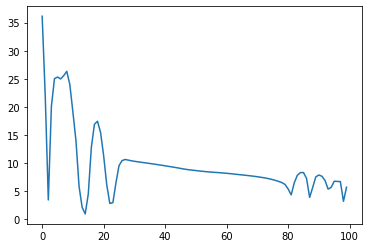

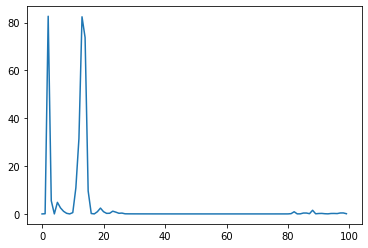

In [32]:
plt.plot(np.arange(len(g_losses)), g_losses)
plt.show()

plt.plot(np.arange(len(d_losses)), d_losses)
plt.show()



In [34]:
util.clear_mem(True)

In [37]:
with torch.no_grad():
    Y_test_pred = model_g(X_test.to(device,dtype)).cpu()

print('Test Loss: ', generator_loss_function_base(Y_test_pred, Y_test, X_test).item())


22.33026695251465+143.15707397460938+0.0=165.48733520507812
Test Loss:  165.48733520507812


Showing example:  0
Input:


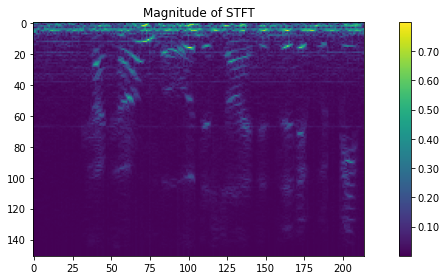

Target:


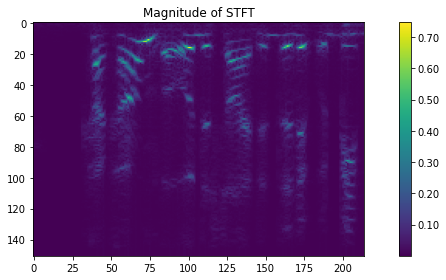

Output:


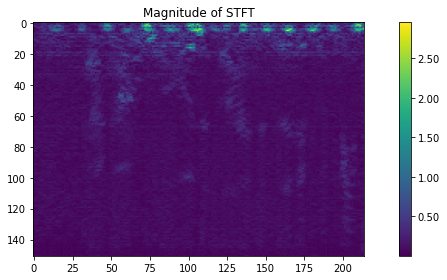

In [38]:
test_example_idx = 0
print('Showing example: ', test_example_idx)
print('Input:')
audionnio.show_play_nn_input(X_test, X_test_phase, ts=['mag', 'audio'], sample_idx=test_example_idx)
print('Target:')
audionnio.show_play_nn_output(Y_test, X_test, X_test_phase, ts=['mag', 'audio'], sample_idx=test_example_idx)
print('Output:')
audionnio.show_play_nn_output(Y_test_pred, X_test, X_test_phase, ts=['mag', 'audio'], sample_idx=test_example_idx)